In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.special import gamma
from scipy.special import gammaln
from scipy.optimize import differential_evolution

from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from concurrent.futures import ThreadPoolExecutor, as_completed
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
from functions import compute_r, rho_model, log_rho_model, compute_r_fast, rho_model_fast

plt.style.use('ggplot')

In [3]:
coordinates_df = pd.read_csv('../data/coordinates.csv')

n_events = 100

X = coordinates_df['X']
Y = coordinates_df['Y']
Z = coordinates_df['Z']


Ne, s = 1e6, 1.2
theta, phi = 30, 210
Z0 = - 18
X0_array = np.random.uniform(-40, 40, size=n_events)
Y0_array = np.random.uniform(-70, 70, size=n_events)

initial_params = [0,  0,  1e5, 1.5]
bounds = [
    (-50, 50),  # X0
    (-80, 80),  # Y0
    (1, 1e8),  # Ne
    (0.2, 2)  # s
]

In [4]:
def loss_function(params, coordinates_df, rho, theta, phi, Z0):
    X0, Y0, Ne, s = params
    X_det, Y_det, Z_det = coordinates_df[['X', 'Y', 'Z']].values.T
    r = compute_r(X0, Y0, Z0, theta, phi, X_det, Y_det, Z_det)
    rho_calc = rho_model(r, Ne, s)
    # return np.mean((rho_calc - rho) ** 2)
    return np.mean((np.log(rho_calc) - np.log(rho)) ** 2)

In [283]:
def add_noise(rho, noise_level=0.1, threshold=None):
    """Добавляет гауссов шум к значениям rho"""
    noise = np.random.normal(loc=0, scale=noise_level *
                             np.abs(rho), size=rho.shape)
    rho_noisy = rho + noise
    if threshold is not None:
        rho_noisy = np.maximum(rho_noisy, threshold)
        
    return rho_noisy

In [291]:
def find_params(coordinates, theta, phi, X0_array, Y0_array, Z0, Ne, s, n_clusters=9, noise_level=0):
    r_list, rho_list = [], []
    X0_list, Y0_list = [], []
    Ne_list, s_list = [], []
    mrpe_list = []
    R_list, RHO_list = [], []
    used_clusters_list = []
    rho_noisy_list = []
    
    unique_clusters = coordinates['cluster'].unique()
    
    threshold = 1 * 8.2 /  (0.4 * 0.4 * 4)

    for i in tqdm(range(n_events), desc="Processing events"):
        # случайный выбор кластеров
        selected_clusters = np.random.choice(unique_clusters, size=n_clusters, replace=False)
        used_clusters_list.append(selected_clusters)
        
        # фильтрация по кластерам
        cluster_mask = coordinates['cluster'].isin(selected_clusters)
        selected_coords = coordinates[cluster_mask].copy()  # Создаем копию для безопасности
        
        X_det_all, Y_det_all, Z_det_all = selected_coords[['X', 'Y', 'Z']].values.T
        
        # r и rho для выбранных кластеров
        X0, Y0 = X0_array[i], Y0_array[i]
        r_all = compute_r(X0, Y0, Z0, theta, phi, X_det_all, Y_det_all, Z_det_all)
        rho_all = rho_model(r_all, Ne, s)
        
        # фильтрация по порогу
        threshold_mask = rho_all >= threshold
        final_coords = selected_coords[threshold_mask]
        final_rho = rho_all[threshold_mask]
        rho_noisy = add_noise(final_rho, noise_level=noise_level, threshold=threshold * 3 / 4)
        final_r = r_all[threshold_mask]
        
        if len(final_rho) == 0:
            continue  

        X_det, Y_det, Z_det = final_coords[['X', 'Y', 'Z']].values.T

        result = differential_evolution(
            loss_function,
            bounds,
            args=(final_coords, rho_noisy, theta, phi, Z0)
        )
        
        result = minimize(
            loss_function, 
            result.x, 
            args=(final_coords, rho_noisy, theta, phi, Z0),
            method='Nelder-Mead', 
            bounds=bounds
        )
        
        X0_opt, Y0_opt, Ne_opt, s_opt = result.x
        
        R = compute_r(X0_opt, Y0_opt, Z0, theta, phi, X_det, Y_det, Z_det)
        RHO = rho_model(R, Ne_opt, s_opt)
        
        mrpe = np.mean(np.abs((RHO - rho_noisy) / rho_noisy))
        
        mrpe_list.append(mrpe)
        r_list.append(final_r)
        R_list.append(R)
        rho_list.append(final_rho)
        rho_noisy_list.append(rho_noisy)
        RHO_list.append(RHO)
        X0_list.append(X0_opt)
        Y0_list.append(Y0_opt)
        Ne_list.append(Ne_opt)
        s_list.append(s_opt)

    return (
        r_list,
        R_list,
        rho_list,
        rho_noisy_list,
        RHO_list,
        X0_list,
        Y0_list,
        Ne_list,
        s_list,
        mrpe_list,
        threshold_mask
    )

In [335]:
noise_level = 20

In [336]:
results  = find_params(coordinates_df, theta, phi, X0_array, Y0_array, Z0, Ne, s, n_clusters=5, noise_level=noise_level / 100)
r_array, R_array, rho_array, rho_noisy_array, RHO_array, X0_opt_array, Y0_opt_array, Ne_opt_array, s_opt_array, mrpe_array, mask = results

Processing events: 100%|██████████| 100/100 [03:39<00:00,  2.20s/it]


In [339]:
results1  = find_params(coordinates_df, theta, phi, X0_array, Y0_array, Z0, Ne=1e5, s=1.2, n_clusters=5, noise_level=noise_level / 100)
r_array1, R_array1, rho_array1, rho_noisy_array1, RHO_array1, X0_opt_array1, Y0_opt_array1, Ne_opt_array1, s_opt_array1, mrpe_array1, mask1 = results1

Processing events: 100%|██████████| 100/100 [23:36<00:00, 14.17s/it]


In [ ]:
delta_X0 = np.array(X0_opt_array) - np.array(X0_array)
delta_Y0 = np.array(Y0_opt_array) - np.array(Y0_array)
delta_Ne = [(Ne_opt - Ne) / Ne for Ne_opt in Ne_opt_array]
delta_s = [(s_opt - s) / s for s_opt in s_opt_array]

In [329]:
np.mean(mrpe_array)

0.20217062462561317

In [330]:
# delta_X0 = np.asarray(delta_X0)
# delta_Y0 = np.asarray(delta_Y0)
# delta_Ne = np.asarray(delta_Ne)
# delta_s = np.asarray(delta_s)

# # Теперь можно использовать булеву индексацию
# delta_X0[np.abs(delta_X0) > 20] = 0
# delta_Y0[np.abs(delta_Y0) > 20] = 0
# delta_Ne[np.abs(delta_Ne) > 1] = 0
# delta_s[np.abs(delta_s) > 0.2] = 0

In [331]:
def find_limit(nums):
    return abs(max(nums, key=lambda x: abs(x)))

In [332]:
print(f"Ne = {Ne:.2e}, s = {s}")

Ne = 1.00e+06, s = 1.2


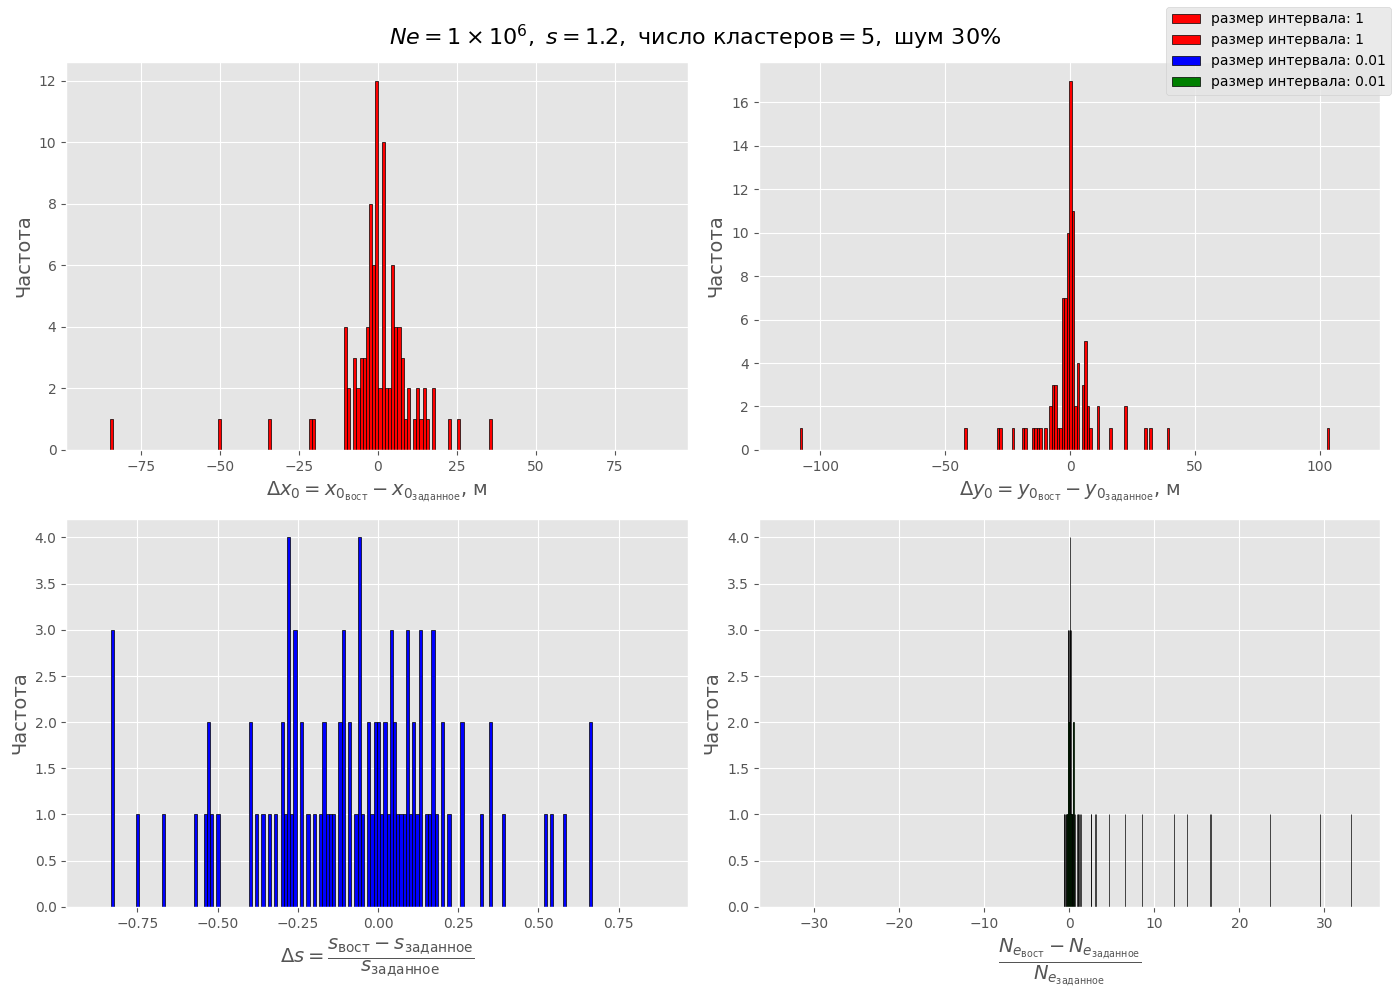

In [ ]:
interval_delta_X = 1
interval_delta_Y = 1

interval_delta_s = 0.01
interval_delta_Ne = 0.01

limit_X, limit_Y = find_limit(delta_X0), find_limit(delta_Y0)
limit_Ne, limit_s = find_limit(delta_Ne), find_limit(delta_s)

bin_edges_delta_X = np.arange(-limit_X - 5, limit_X + 5, interval_delta_X)
bin_edges_delta_Y = np.arange(-limit_Y - 5, limit_Y + 5, interval_delta_Y)

bin_edges_delta_s = np.arange(-limit_s - 0.05, limit_s + 0.05, interval_delta_s)
bin_edges_delta_Ne = np.arange(-limit_Ne - 0.05, limit_Ne + 0.05, interval_delta_Ne)


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(r'$Ne=1\times10^6,\ s=1.2,\ \text{число кластеров}=5,\ \text{шум}\ 30\%$', fontsize=16)
# delta_X
axes[0, 0].hist(delta_X0, bins=bin_edges_delta_X,
                edgecolor='black', color='red', label=f'размер интервала: {interval_delta_X}')
axes[0, 0].set_xlabel(
    r'$\Delta x_0 = x_{0_{\text{вост}}} - x_{0_{\text{заданное}}}$, м', fontsize=14)
axes[0, 0].set_ylabel("Частота", fontsize=14)

# delta_Y
axes[0, 1].hist(delta_Y0, bins=bin_edges_delta_Y,
                edgecolor='black', color='red', label=f'размер интервала: {interval_delta_Y}')
axes[0, 1].set_xlabel(
    r'$\Delta y_0 = y_{0_{\text{вост}}} - y_{0_{\text{заданное}}}$, м', fontsize=14)
axes[0, 1].set_ylabel("Частота", fontsize=14)

# delta_s
axes[1, 0].hist(delta_s, bins=bin_edges_delta_s, edgecolor='black',
                color='blue', label=f'размер интервала: {interval_delta_s}')
axes[1, 0].set_xlabel(
    r'$\Delta s = \dfrac{s_{\text{вост}} - s_{\text{заданное}}}{s_{\text{заданное}}}$',  fontsize=14)
axes[1, 0].set_ylabel("Частота",  fontsize=14)

# delta_Ne
axes[1, 1].hist(delta_Ne, bins=bin_edges_delta_Ne,
                edgecolor='black', color='green', label=f'размер интервала: {interval_delta_Ne}')
axes[1, 1].set_xlabel(
    r'$\dfrac{N_{e_{\text{вост}}} - N_{e_{\text{заданное}}}}{N_{e_{\text{заданное}}}}$',  fontsize=14)
axes[1, 1].set_ylabel("Частота",  fontsize=14)


# data = pd.DataFrame(
#     {'delta_r': np.array(delta_r).reshape(-1, 36).tolist, 'delta_s': delta_s, 'delta_Ne': delta_Ne})
# data.to_csv(f'plots/{model_number}/delta_r,s,Ne.csv', index=False)

plt.tight_layout()
plt.savefig(f'plots_testing/Ne=1e6_s=1.2/delta_r,s=1.2,Ne=1e6,clasters=5_noise0{noise_level}_legendoff.png',
            dpi=500, bbox_inches="tight")

# fig.legend()
# plt.savefig(f'plots_testing/Ne=1e6_s=1.2/delta_r,s=1.2,Ne=1e6,clasters=5_noise0{noise_level}.png',
#             dpi=500, bbox_inches="tight")
plt.show()

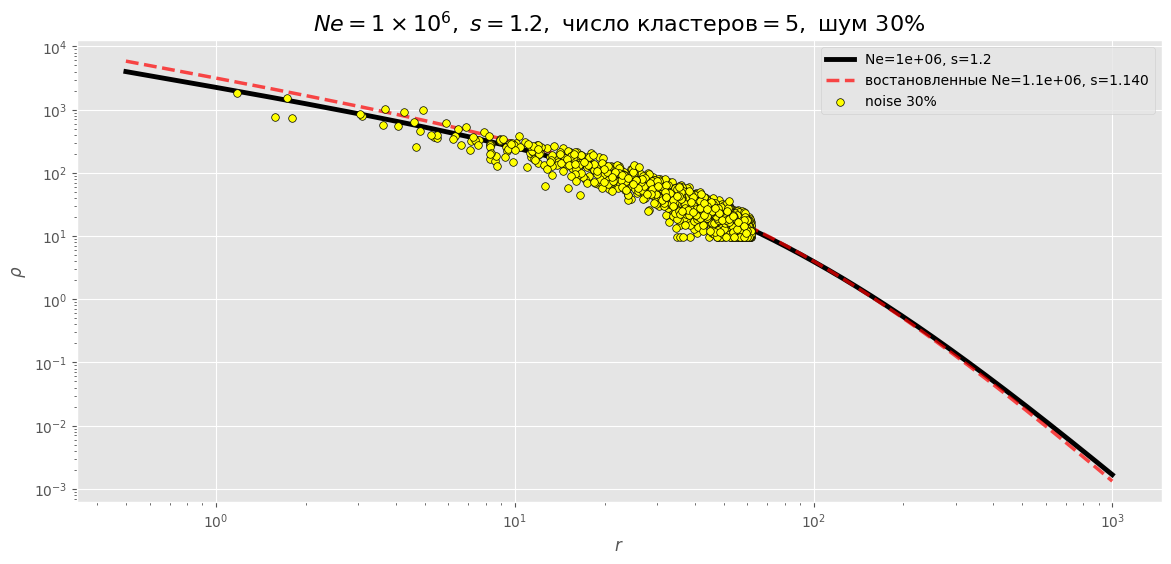

In [334]:
r = np.arange(0, 1e3, 0.5)
rho = rho_model(r, Ne, s)

Ne_opt = np.median(Ne_opt_array)
s_opt = np.median(s_opt_array)
rho_opt = rho_model(r, Ne_opt, s_opt)

all_r = np.concatenate(r_array)
all_rho = np.concatenate(rho_noisy_array)

plt.figure(figsize=(14, 6))
plt.title(r'$Ne=1\times10^6,\ s=1.2,\ \text{число кластеров}=5,\ \text{шум}\ 30\%$', fontsize=16)
plt.plot(r, rho, 
         label=f"Ne={Ne:.0e}, s={s}",
         color='black',
         linestyle='-',
         linewidth=3.5,
         alpha=1,
         zorder=1)

plt.plot(r, rho_opt,
         label=f"востановленные Ne={Ne_opt:.1e}, s={s_opt:.3f}", 
         color='red',
         linestyle='--',
         linewidth=2.5,
         alpha=0.7,
         zorder=2)

plt.scatter(all_r, all_rho,
            label=f"noise {noise_level}%",
            marker='o',
            s=30,
            color='yellow',
            edgecolor='black',
            alpha=1,
            zorder=3)


plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$r$")
plt.ylabel(r"$\rho$")
plt.legend()
plt.grid(True)
plt.savefig(f'plots_testing/Ne=1e6_s=1.2/rho(r),Ne=1e6,clasters=5_noise0{noise_level}.png',
            dpi=500, bbox_inches="tight")
plt.show()

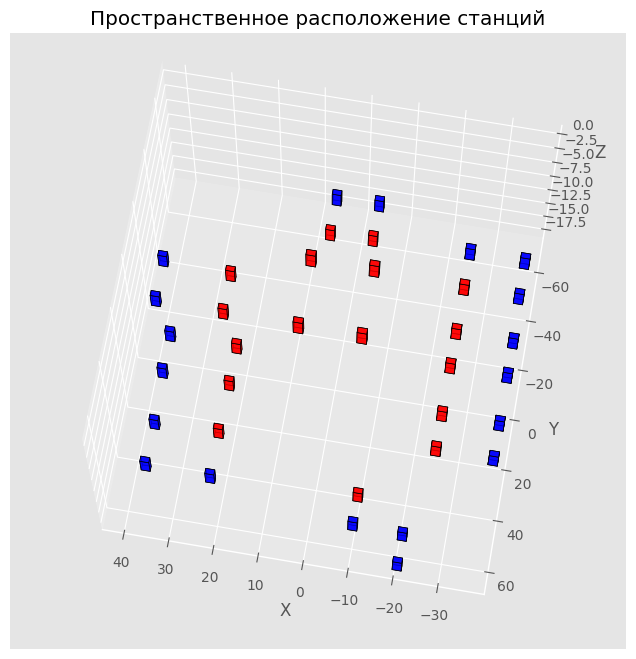

In [346]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

df = coordinates_df
central_stations = [1.1, 1.4, 2.1, 2.4, 3.1, 3.2, 3.3, 3.4, 
                    4.3, 4.2, 5.3, 6.1, 6.2, 7.4, 8.2, 8.3, 9.1]

cube_size = 2
def draw_cube(ax, x, y, z, size, color):
    r = [-size/2, size/2]
    vertices = [[x+r[i], y+r[j], z+r[k]] for i in range(2) for j in range(2) for k in range(2)]
    faces = [
        [vertices[0], vertices[1], vertices[3], vertices[2]],  # Bottom face
        [vertices[4], vertices[5], vertices[7], vertices[6]],  # Top face
        [vertices[0], vertices[1], vertices[5], vertices[4]],  # Front face
        [vertices[2], vertices[3], vertices[7], vertices[6]],  # Back face
        [vertices[0], vertices[2], vertices[6], vertices[4]],  # Left face
        [vertices[1], vertices[3], vertices[7], vertices[5]],  # Right face
    ]
    ax.add_collection3d(Poly3DCollection(faces, color=color, edgecolor="k", alpha=0.8))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for _, row in df.iterrows():
    color = "red" if row["station"] in central_stations else "blue"
    draw_cube(ax, row["X"], row["Y"], row["Z"], cube_size, color)

ax.set_xlim(df["X"].min() - 1, df["X"].max() + 1)
ax.set_ylim(df["Y"].min() - 1, df["Y"].max() + 1)
ax.set_zlim(df["Z"].min() - 1, df["Z"].max() + 1)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.view_init(elev=70, azim=100)
ax.set_title("Пространственное расположение станций")

plt.show()